# Project Proposal: Predicting User Knowledge from Study Habits and Exam Performance


## Introduction: Data set and background information

### About the data set

**Our data set:** [User Knowledge Modeling](https://doi.org/10.24432/C5231X)

We have chosen to explore the user User Knowledge Modeling data set ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)), which is a data set that classifies users' knowledge of a topic (Electrical DC machines).

There are 6 total variables in the data set: 5 features and 1 target.

Features: <br>
A) Goal topics (learning objects):
- The degree of time spent studying the material [STG]
- The degree of repetition of the material [SCG]
- The performance in exams [PEG]

B) Prerequisite topics
- The degree of study time corresponding to the prerequisite objects [STR]
- The knowledge level of the prerequisite objects [LPR]

Target:
- user knowledge [UNS].

UNS has four levels: very low, low, middle, high. In order, this corresponds to the user's knowledge beginner, intermediate, expert, advanced ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

### Background Information

#### User Modeling and User Knowledge

User modeling is a way to personalize a user's experience by tracking user interactions with a web page and using that information to optimize their future interactions ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). Some examples of user interactions could be pages the user has visited, the time spent on pages, and keystrokes ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). This data is collected and can be used to track the user's activities, especially when modeling user knowledge ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

User knowledge models can be used to evaluate and dynamically shape the learning experience of an individual, especially when it applies to an online learning environment ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). 

### Our Question

The question we are trying to answer is:

**Can we predict the knowledge level of a user given the time they spent studying and their performance on the exam?**

## Preliminary exploratory data analysis

### Loading necessary libraries and reading in the data

In [12]:
#load all necessarily libraries
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn") # this library needs to be loaded in for future classification
library(kknn)
install.packages("RColorBrewer")
library(RColorBrewer)

#read data from the web (GitHub raw file)
dc_machines <- read_csv("https://raw.githubusercontent.com/afellhauer/DSCI_Group_Project/main/data/Data_User_Modeling_Dataset_Hamdi.csv")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Rows: 258 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Make data usable and readable

In order for us to analyze the data, we need to make sure the variables are classified as the correct data types. UNS (user_knowledge), which is the variable that will be used to label the class, needs to be converted from a character to a factor. All variables were renamed to increase comprehension.  

In [2]:
dc_machines_mutate <- dc_machines |>
    mutate(UNS = as_factor(UNS)) |> #change the class from a chr to a factor
    rename("study_time_goal" = STG, #relabel all variables to understand them better
           "repitition" = SCG,
           "study_time_related" = STR,
           "performance_related" = LPR, 
           "performance_goal" = PEG,
           "user_knowledge" = UNS)
glimpse(dc_machines_mutate) # check out the data

Rows: 258
Columns: 6
$ study_time_goal     <dbl> 0.00, 0.08, 0.06, 0.10, 0.08, 0.09, 0.10, 0.15, 0.…
$ repitition          <dbl> 0.00, 0.08, 0.06, 0.10, 0.08, 0.15, 0.10, 0.02, 0.…
$ study_time_related  <dbl> 0.00, 0.10, 0.05, 0.15, 0.08, 0.40, 0.43, 0.34, 0.…
$ performance_related <dbl> 0.00, 0.24, 0.25, 0.65, 0.98, 0.10, 0.29, 0.40, 0.…
$ performance_goal    <dbl> 0.00, 0.90, 0.33, 0.30, 0.24, 0.66, 0.56, 0.01, 0.…
$ user_knowledge      <fct> very_low, High, Low, Middle, Low, Middle, Middle, …


### Set seed in order to make data reproducible

As the following functions (initial_split) is includes random sampling, we set the seed to ensure reproducibility.

In [3]:
set.seed(200)

### Split the data into training and testing sets

We decided to use a proportion of 0.75 for the training to testing ratio. We also stratified the data using user_knowledge, which is the class we are trying to predict. 

In [4]:
#create the initial split of the data using the desired proportion of training to testing ratio
#stratify based on user_knowledge
dc_machines_split <- initial_split(dc_machines_mutate, prop = 0.75, strata = user_knowledge)

#collected the testing and training portions
dc_machines_training <- training(dc_machines_split)
dc_machines_testing <- testing(dc_machines_split)

### Summarizing the data

We first examined how balanced or unbalanced the data set is. We created a table that summarized the number of counts for each group of the user_knowledge variable. 

The very_low (beginner) knowledge level is not as represented in this dataset.

In [5]:
summary_counts <- dc_machines_training |>
    group_by(user_knowledge) |> #group based on the class
    summarize(count = n()) #gets the count (number of observations of each)
summary_counts

user_knowledge,count
<fct>,<int>
very_low,20
High,47
Low,59
Middle,66


**Table 1**: Proportion of observations classified as each user knowledge level (very_low, low, high, middle)

We then summarized at the means of our predictors for each class.

In [37]:
summary <- dc_machines_training |>
    select(user_knowledge, study_time_goal, performance_goal) |> #select only the class and the predictors
    group_by(user_knowledge) |>
    summarize("mean_study_time" = mean(study_time_goal), "mean_exam_score" = mean(performance_goal)) 
    #get the mean for each predictor for each group
summary

user_knowledge,mean_study_time,mean_exam_score
<fct>,<dbl>,<dbl>
very_low,0.3172000,0.0985000
High,0.4220000,0.7646809
Low,0.3249831,0.2386949
Middle,0.4147727,0.5430303


**Table 2**: Mean study time and mean exam score for each user knowledge level (very_low, low, middle, high)

### Visualize the data

We visualized the distribution of the different groups according to their counts. Again, this highlights that the data is not completely balanced.

*To left align the caption, we used [this code](https://stackoverflow.com/questions/64701500/left-align-ggplot-caption)*.

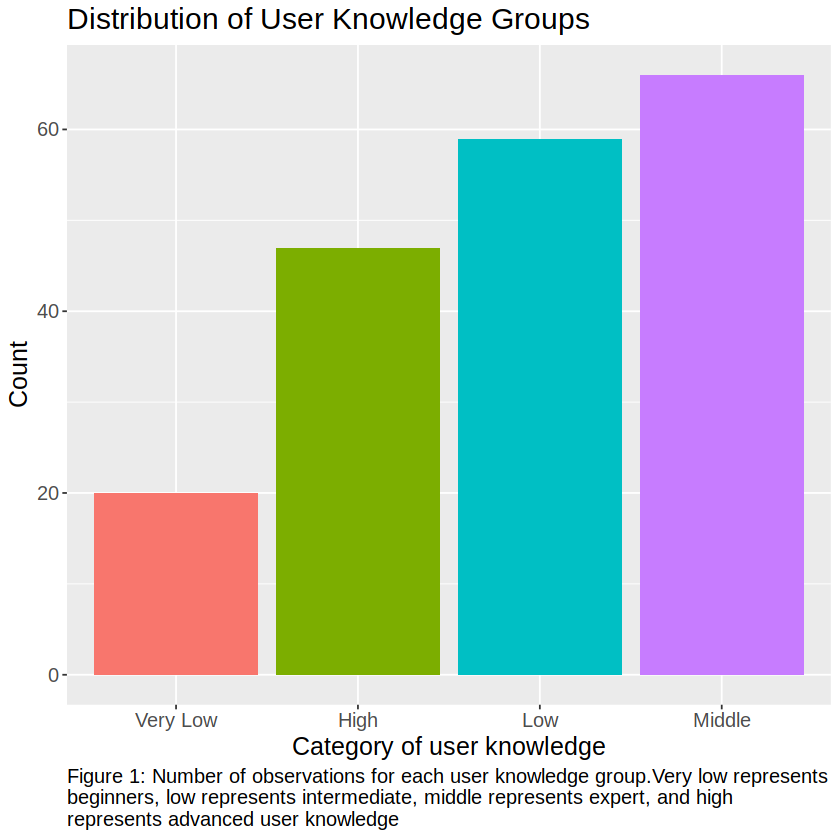

In [35]:
dc_machines_plot_distribution <- dc_machines_training |>
    ggplot(aes(x = fct_recode(user_knowledge, "Very Low" = "very_low"), fill = user_knowledge)) + #change the label of very_low to Very Low
    geom_bar() + #use the default stat = "count"
    xlab("Category of user knowledge") +
    ylab("Count")

#make the plot look nicer
dc_machines_plot_distribution <- dc_machines_plot_distribution +
    theme(text = element_text(size = 15), legend.position = "none", #remove the legend
         plot.caption = element_text(hjust = 0)) + #set the text to left align
    ggtitle("Distribution of User Knowledge Groups") +
    labs(caption = "Figure 1: Number of observations for each user knowledge group.Very low represents 
beginners, low represents intermediate, middle represents expert, and high 
represents advanced user knowledge") +
    scale_color_brewer(palette = "Set2") #set the color palette
    
dc_machines_plot_distribution

Then, we plotted the data according to study time and exam performance of each of the user knowledge groups. We start to see some distinct groups form.

*To left align the caption, we used [this code](https://stackoverflow.com/questions/64701500/left-align-ggplot-caption)*.

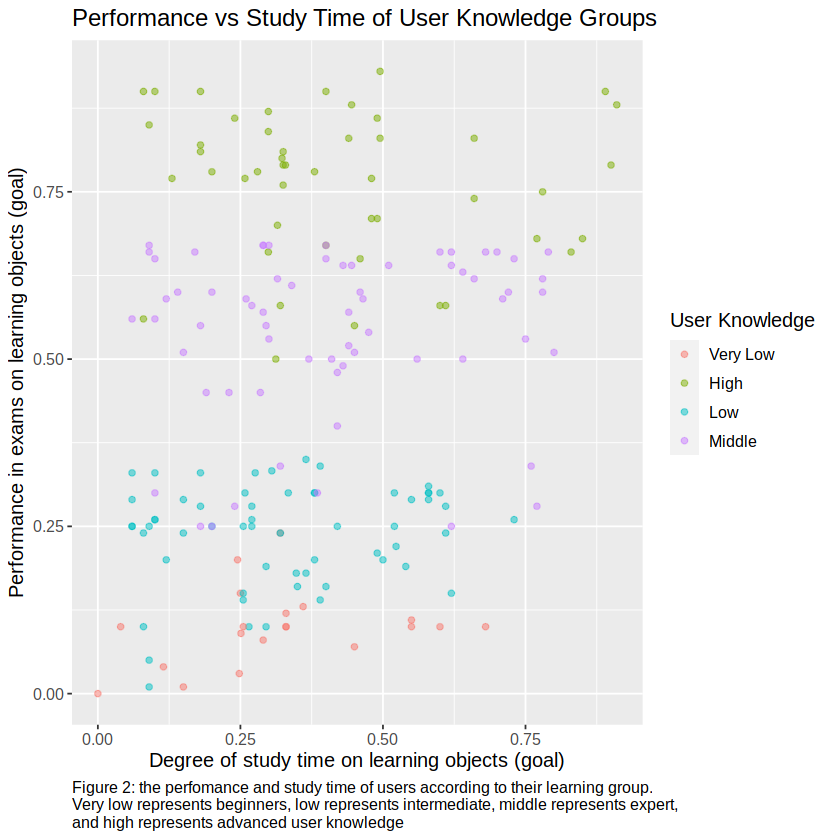

In [26]:
dc_machines_plot_study_vs_goal <- dc_machines_training |>
    ggplot(aes(x = study_time_goal, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of study time on learning objects (goal)") +
    ylab("Performance in exams on learning objects (goal)") +
    labs(color = "User Knowledge", 
        caption = "Figure 2: the perfomance and study time of users according to their learning group.
Very low represents beginners, low represents intermediate, middle represents expert, 
and high represents advanced user knowledge") +
    theme(text = element_text(size = 12), plot.caption = element_text(hjust = 0)) +
    ggtitle("Performance vs Study Time of User Knowledge Groups")
dc_machines_plot_study_vs_goal

## Methods

### Classification System

K-Nearest Neighbors (KNN) is a classification method that predicts the classification of new, unlabeled observations based on the classes of its closest neighbors. KNN uses the distance between two points (Euclidean distance) in order to determine the proximity to each point to the new observation, then conducts of vote using the the chosen number of neighbors (K). Each nearby neighbour gets one vote (rectangular weight function), and the unlabeled observation is given the classification according to whichever class contributes the greatest number of votes ([Timbers et al., 2023](https://datasciencebook.ca/)). 

We will be using KNN in our project to determine if the user knowledge level of individual can be predicted using their study habits and exam performance. 

We will conduct our data analysis using **KNN classification** since we are predicting a categorical variable. We will be predicting user_knowledge. The variables we are going to use to predict are:
- study_time_goal
- performance_goal

### Steps

1.  Build the recipe using user_knowledge as the classifier, study_time_goal and performance_goal as the predictors, and the training set as the data.  
2.  Choose the appropriate K-value for the training set using 5-Fold Cross-Validation and compare accuracy for each selectio  of K (tune the model).
3.  Create the KNN model using the selected K value.
4.  Train the classifier using the training set.
5.  Predict the labels for the unseen testing set.
6.  Evaluate accuracy and create a confusion matrix to assess precision and recall.
7.  Analyze performance using precision, recall, and accuracy.
8.  Discuss outcomes and suggestions for improving the model.

## Expected Outcomes and Significance

We expect to see that exam performance and study time are good predictors of user knowledge.

We believe that these findings could contribute to predicting user knowledge for web-based learning applications (Kahraman, Colak, & Sagiroglu, 2013).

Future questions that this could lead to include how we can adjust the tasks for students learning a topic (learning level) in order to create a dynamic and adaptive learning experience. For example, the creation of an intelligent artificial tutor that could tailor content based on user knowledge.

# References

[1](https://doi.org/10.1016/j.knosys.2012.08.009) Kahraman, H. T., Sagiroglu, S., &amp; Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of Domain Dependent Data. *Knowledge-Based Systems, 37*, 283–295. https://doi.org/10.1016/j.knosys.2012.08.009 

[2](https://doi.org/10.24432/C5231X) Kahraman, H. T., Colak, I., & Sagiroglu, S. (2013). User Knowledge Modeling. *UCI Machine Learning Repository*. https://doi.org/10.24432/C5231X.

[3](https://datasciencebook.ca/) Timbers, T., Campbell, T., & Lee, M. (2023) Data Science: A First Introduction. CRC Press, Taylor & Francis Group. https://datasciencebook.ca/